In [7]:
# Add in the neccesary libraries and depedencies
# First precompile takes more time -> Julia creates a type structure so that it can exploit the JIT feature
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using Combinatorics
using LaTeXStrings
using Colors
using Compose
using Images

Makie.inline!(true)

true

__The plan:__

-__Step 1__: use Graphs.jl to get all possible spanning tree on n nodes => plot the results

In [8]:
# Some helper functions which will be usefull for explorer all possible spanning trees in a NetworkLayout
# A function which returns true or false based on if an list of edges is the representation of a tree or not


function graph_is_tree(edge_list, vertices_list)

    """ 
    Helper function which checks is a list of edges is a tree based on a given vertices_list
    This is done by checking if there are nv(G)-1 edges in this proposed graph
    The connectivity condition is evaluated as well
    """

    # Check the nv(G)- 1 edges condition
    if length(edge_list) != length(vertices_list)-1
        return false
    end

    sort!(vertices_list) # sort the vertices_list for comparisson purposes

    # Extract unique elements from the tuples
    unique_elements = Set(v for tpl in edge_list for v in tpl)
    # Convert the Set to a sorted list for comparisson
    unique_elements_list = sort(collect(unique_elements))
    
    print(vertices_list)
    # Check the connectivity condition
    if unique_elements_list == vertices_list 
        return true
    end

    return false 

end


function generate_combinations(full_edge_list, length)

    """
    Helper function created using the Combinatorics.jl package.
    Based on a input list of edges this function generates all possible combinations of a certain length
    If length is set to nv(G)-1 this generates all possible edge lists which could be trees
    """
    
    # Create a list to store all the combinations
    all_combinations = [combo for combo in combinations(full_edge_list, length)]

    return all_combinations
end




generate_combinations (generic function with 1 method)

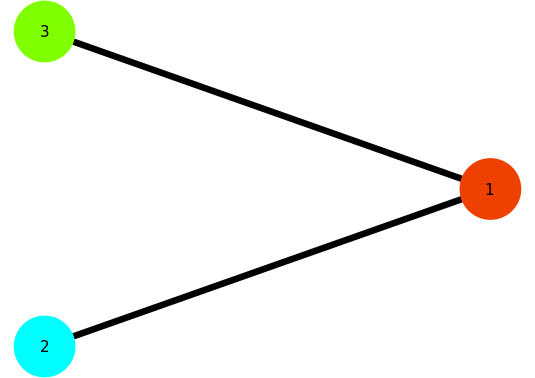

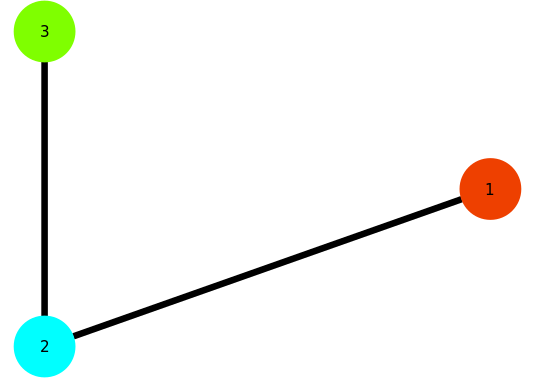

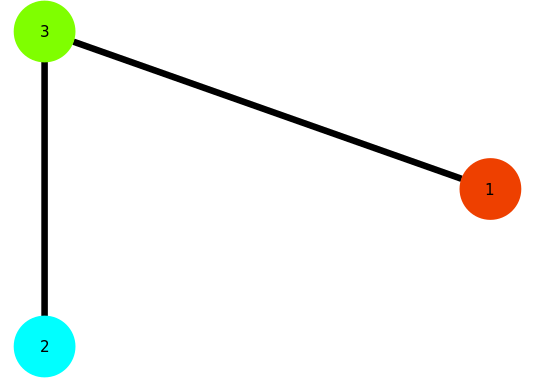

[1, 2, 3][1, 2, 3][1, 2, 3]

In [18]:
function generate_all_possible_looptotree_replacements(n)

    """ 
    This function takes in a number n which represents the amount of vertices in the loop which we want to replace.
    The is done purely on graph-level reasoning, the fact that the graph represents a complex network of interconnected tensors is not yet taking into account.
    The function returns a list of simple graphs which are the possible spanning tree replacements for this tensor loop.
    """

    # Generate a complete graph of order n to extract all possible spanning trees on this graph structure
    G = Graphs.complete_graph(n)
    node_coloring = [colorant"orangered2", colorant"cyan", colorant"chartreuse", colorant"goldenrod1", colorant"purple", colorant"lightskyblue4
    ", colorant"mediumpurple1"][1:nv(G)]
    nodes = [node for node in vertices(G)]      
    number_of_spanning_trees = n^(n-2)
    # create a masterlist which is the set of all edges represented as a sorted (Read undirected) tuple of vertices.
    masterlist = [Tuple(sort([src(edge), dst(edge)])) for edge in edges(G)] 


    # Generate the list of all edges which possibly could be a tree and filter out the ones which are not  a tree
    tree_like = generate_combinations(masterlist, length(nodes)-1)

    # Generate all possible spanning trees by checking if their is no loop in the tree_like edge list
    all_spanning_trees = [tree for tree in tree_like if graph_is_tree(tree, nodes) == true]
 
    # Creating a list of graphs objects for all the trees
    spanning_tree_graphs = []
    for spanningtree_edges in all_spanning_trees
        # Example usage
        g  = SimpleGraph(n)
        for edge in spanningtree_edges
            add_edge!(g, edge[1], edge[2])
        end
        if is_tree(g) == true # extra condition for the n = 5 case -> my graph_is_tree_function doesn't catch the disconnected subloops.
            push!(spanning_tree_graphs, g)
        end
    end


    return spanning_tree_graphs
end


spanning_tree_graphs = generate_all_possible_looptotree_replacements(3)
for tree in spanning_tree_graphs
    node_coloring = [colorant"orangered2", colorant"cyan", colorant"chartreuse", colorant"goldenrod1", colorant"purple", colorant"lightskyblue4
    ", colorant"mediumpurple1"][1:nv(tree)]
    nodes = [node for node in vertices(tree)]
    display(gplot(tree, nodefillc=node_coloring, nodelabel=nodes, edgestrokec=colorant"black", layout=circular_layout))
end


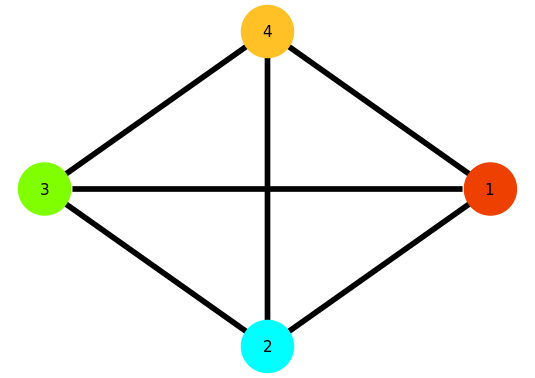

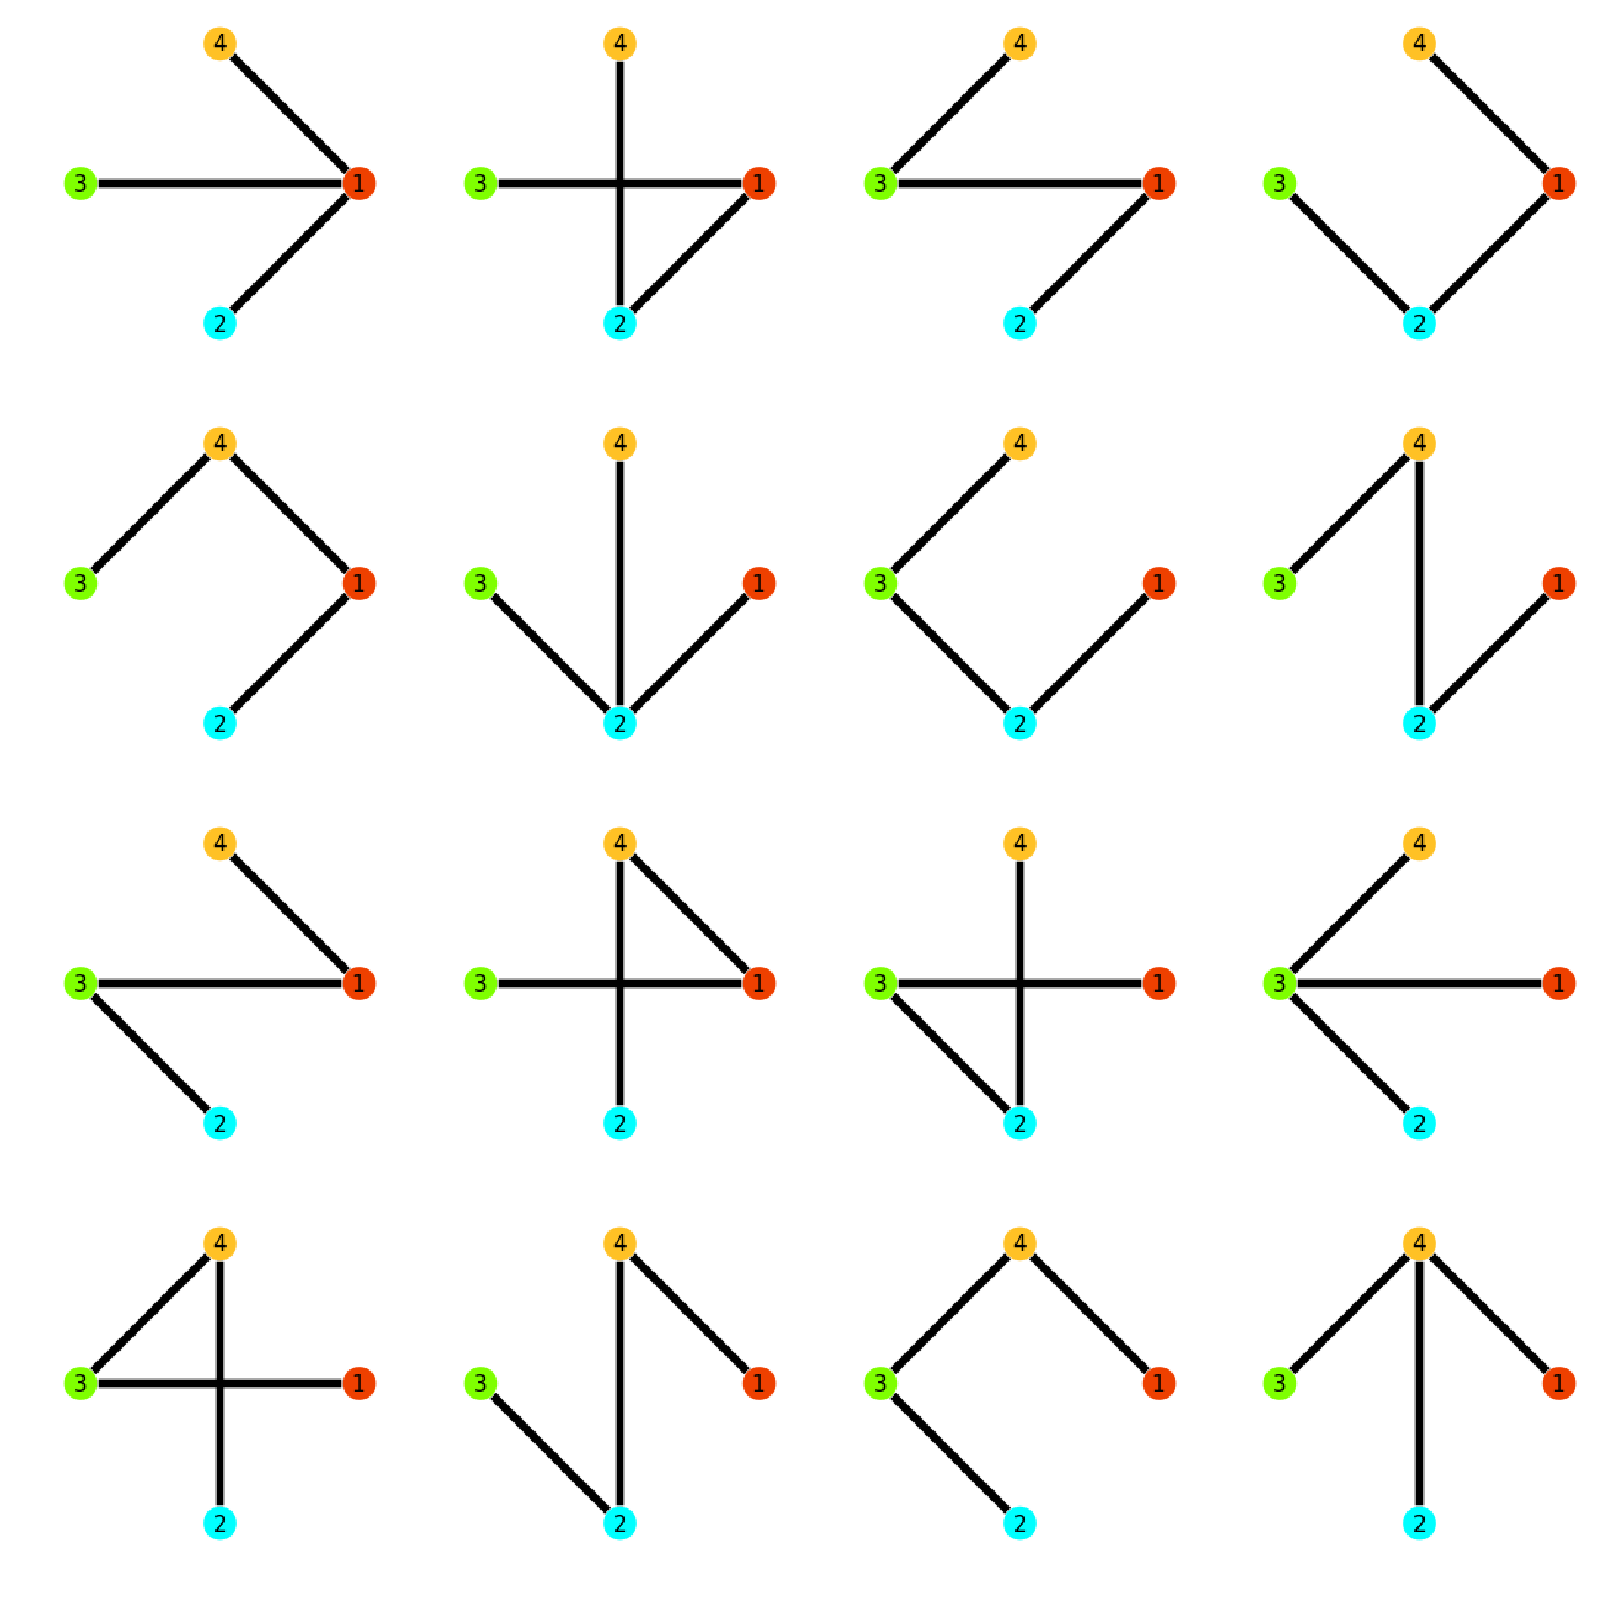

[1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4][1, 2, 3, 4]

In [11]:
function generate_and_plot_all_spanning_trees(n, plotting=false)

    """
    Function which takes in n == amount of tensors in a loop.
    Based on possible spanning trees inside of a complete graph we can get the combinatorics of all possible spanning trees.

    eg. Some possible loop -> tree structures for n_vertices = 4
    0 --- 0                 0 --- 0                 0     0
    |     |                 |     |                 |   / |
    |     |         =       |     |             or  |  /  |
    0 --- 0                 0     0                 0     0

    Each loopless and distinct way of interconnecting the Tensors inside the loop is a different graph structure corresponding to one of the spanning trees on these n vertices.
    All the possible spanning trees can also be distilled by looking at the complete graph of order n and looking at all possible spanning subgraph which are trees.
    This function provides based on a certain loop of tensors all possible ways of interconnecting them as a spanning tree.
    """
    
    # Generate and visualisation of the initial complete graph related to the n-tensor loop
    G = Graphs.complete_graph(n)
    node_coloring = [colorant"orangered2", colorant"cyan", colorant"chartreuse", colorant"goldenrod1", colorant"purple", colorant"lightskyblue4
    ", colorant"mediumpurple1"][1:nv(G)]
    nodes = [node for node in vertices(G)]
    edgesgraph = [edge for edge in edges(G)]
    edges_tree = [edge for edge in edgesgraph[1:Int(floor(length(edgesgraph)/2))]]
    edge_coloring = []
    # Selective edge_coloring
    for edge in edgesgraph
        if edge ∈ edges_tree
            push!(edge_coloring, colorant"black")
        else
            push!(edge_coloring, colorant"grey99")
        end
    end

    if plotting == true
        # Displaying the fully connected graph to reason from
        display(gplot(G, nodefillc=node_coloring, nodelabel=nodes, edgestrokec=colorant"black", layout=circular_layout))
    end

    # Now the main part of the code in this function -> Generates the underlying spanning subtrees

    number_of_spanning_trees = n^(n-2)
    masterlist = [Tuple(sort([src(edge), dst(edge)])) for edge in edges(G)]
    
    # Generate the list of all edges which possibly could be a tree and filter out the ones which are not  a tree
    tree_like = generate_combinations(masterlist, length(nodes)-1)

    # Generate all possible spanning trees by checking if their is no loop in the tree_like edge list
    all_spanning_trees = [tree for tree in tree_like if graph_is_tree(tree, nodes) == true]
 
    # Creating a list of graphs objects for all the trees
    spanning_tree_graphs = []
    for spanningtree_edges in all_spanning_trees
        # Example usage
        g  = SimpleGraph(n)
        for edge in spanningtree_edges
            add_edge!(g, edge[1], edge[2])
        end
        if is_tree(g) == true # extra condition for the n = 5 case
            push!(spanning_tree_graphs, g)
        end
    end

    plot_list = []
    file_name_list = []
    # Set the number of rows and columns for the subplot grid
    num_rows = 5
    num_cols = 25

    for (i, tree) in enumerate(spanning_tree_graphs)
        filename = "tree$i.png"
        push!(file_name_list, filename)
        push!(plot_list, draw(PNG(filename, 6cm, 6cm), gplot(tree, nodefillc=node_coloring, nodelabel=nodes, edgestrokec=colorant"black", layout=circular_layout)))
    end

    if n == 4
        plot_list = []
        for name in file_name_list
            img = load(name)
            push!(plot_list, Plots.plot(img,  axis=false, grid=false))
        end

        
        display(Plots.plot(plot_list..., layout = (4, 4), size=(1600, 1600)))

    end


    if n == 5
        # Create a subplot composition with input png objects

        plot_list = []
        for name in file_name_list[1:25]
            img = load(name)
            push!(plot_list, Plots.plot(img,  axis=false, grid=false))
        end

        
        display(Plots.plot(plot_list..., layout = (5, 5), size=(1600, 1600)))

        plot_list = []
        for name in file_name_list[26:50]
            img = load(name)
            push!(plot_list, Plots.plot(img,  axis=false, grid=false))
        end

        
        display(Plots.plot(plot_list..., layout = (5, 5), size=(1600, 1600)))

        plot_list = []
        for name in file_name_list[51:75]
            img = load(name)
            push!(plot_list, Plots.plot(img,  axis=false, grid=false))
        end

        
        display(Plots.plot(plot_list..., layout = (5, 5), size=(1600, 1600)))


        plot_list = []
        for name in file_name_list[76:100]
            img = load(name)
            push!(plot_list, Plots.plot(img,  axis=false, grid=false))
        end

        
        display(Plots.plot(plot_list..., layout = (5, 5), size=(1600, 1600)))

        plot_list = []
        for name in file_name_list[101:125]
            img = load(name)
            push!(plot_list, Plots.plot(img,  axis=false, grid=false))
        end

        
        display(Plots.plot(plot_list..., layout = (5, 5), size=(1600, 1600)))
    end
        
end





generate_and_plot_all_spanning_trees(4, true)

